### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFE,RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data_raw = pd.read_csv('train.csv')

In [3]:
print(data_raw.shape)
print(data_raw.columns)

(116058, 29)
Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13'],
      dtype='object')


In [4]:
data_raw.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


## 1. Data Preprocessing

In [5]:
data_raw.isnull().any()

loan_id                     False
source                      False
financial_institution       False
interest_rate               False
unpaid_principal_bal        False
loan_term                   False
origination_date            False
first_payment_date          False
loan_to_value               False
number_of_borrowers         False
debt_to_income_ratio        False
borrower_credit_score       False
loan_purpose                False
insurance_percent           False
co-borrower_credit_score    False
insurance_type              False
m1                          False
m2                          False
m3                          False
m4                          False
m5                          False
m6                          False
m7                          False
m8                          False
m9                          False
m10                         False
m11                         False
m12                         False
m13                         False
dtype: bool

In [6]:
data_raw.dtypes

loan_id                       int64
source                       object
financial_institution        object
interest_rate               float64
unpaid_principal_bal          int64
loan_term                     int64
origination_date             object
first_payment_date           object
loan_to_value                 int64
number_of_borrowers         float64
debt_to_income_ratio        float64
borrower_credit_score       float64
loan_purpose                 object
insurance_percent           float64
co-borrower_credit_score    float64
insurance_type              float64
m1                            int64
m2                            int64
m3                            int64
m4                            int64
m5                            int64
m6                            int64
m7                            int64
m8                            int64
m9                            int64
m10                           int64
m11                           int64
m12                         

In [7]:
# Extract features having numerical data and categorical data
num_fea = data_raw.select_dtypes(include=np.number)
cat_fea = data_raw.select_dtypes(include=np.object)
print(num_fea.shape,num_fea.columns,cat_fea.shape,cat_fea.columns)





(116058, 24) Index(['loan_id', 'interest_rate', 'unpaid_principal_bal', 'loan_term',
       'loan_to_value', 'number_of_borrowers', 'debt_to_income_ratio',
       'borrower_credit_score', 'insurance_percent',
       'co-borrower_credit_score', 'insurance_type', 'm1', 'm2', 'm3', 'm4',
       'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13'],
      dtype='object') (116058, 5) Index(['source', 'financial_institution', 'origination_date',
       'first_payment_date', 'loan_purpose'],
      dtype='object')


#### Checking Relation among numeric features

In [8]:
num_fea.iloc[:,:11].describe()

,loan_id,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type
count,1.160580e+05,116058.000000,1.160580e+05,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000
mean,5.494155e+11,3.868961,2.082262e+05,292.280997,67.431939,1.593186,30.742293,769.926778,2.786288,459.611565,0.003257
std,2.597560e+11,0.461020,1.146851e+05,89.762415,17.291719,0.491242,9.730798,42.210706,8.096464,381.946926,0.056977
min,1.000009e+11,2.250000,1.100000e+04,60.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.244656e+11,3.500000,1.200000e+05,180.000000,57.000000,1.000000,23.000000,751.000000,0.000000,0.000000,0.000000
50%,5.486239e+11,3.875000,1.830000e+05,360.000000,72.000000,2.000000,31.000000,782.000000,0.000000,740.000000,0.000000
75%,7.743034e+11,4.125000,2.780000e+05,360.000000,80.000000,2.000000,39.000000,800.000000,0.000000,791.000000,0.000000
max,9.999971e+11,6.750000,1.200000e+06,360.000000,97.000000,2.000000,64.000000,840.000000,40.000000,836.000000,1.000000


In [9]:
num_fea.iloc[:,11:].describe()

,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
count,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000,116058.000000
mean,0.003197,0.002059,0.001973,0.002180,0.003533,0.003421,0.004162,0.004825,0.005359,0.006617,0.007109,0.008065,0.005480
std,0.063354,0.051391,0.055427,0.062161,0.082638,0.087553,0.100961,0.113128,0.128242,0.148430,0.162884,0.178128,0.073824
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,1.000000


In [10]:
pd.DataFrame({'Skewness':data_raw.skew()})

,Skewness
loan_id,0.004114
interest_rate,0.051326
unpaid_principal_bal,0.897524
loan_term,-0.692948
loan_to_value,-0.765251
number_of_borrowers,-0.379397
debt_to_income_ratio,-0.194303
borrower_credit_score,-3.570945
insurance_percent,2.743691
co-borrower_credit_score,-0.362473


most of the feature are highly skewed

In [11]:
num_fea.index = num_fea.loan_id
num_fea.drop(['loan_id'],axis=1,inplace=True)
num_fea.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
loan_id,,,,,,,,,,,,,,,,,,,,,
268055008619,4.250,214000,360,95,1.0,22.0,694.0,30.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
672831657627,4.875,144000,360,72,1.0,44.0,697.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,1
742515242108,3.250,366000,180,49,1.0,33.0,780.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
601385667462,4.750,135000,360,46,2.0,44.0,633.0,0.0,638.0,0.0,...,0,0,0,0,0,1,1,1,1,1
273870029961,4.750,124000,360,80,1.0,43.0,681.0,0.0,0.0,0.0,...,3,4,5,6,7,8,9,10,11,1


In [12]:
cat_fea.index = num_fea.index.values

In [13]:
cat_fea.head()

,source,financial_institution,origination_date,first_payment_date,loan_purpose
268055008619,Z,"Turner, Baldwin and Rhodes",2012-03-01,05/2012,C86
672831657627,Y,"Swanson, Newton and Miller",2012-01-01,03/2012,B12
742515242108,Z,Thornton-Davis,2012-01-01,03/2012,B12
601385667462,X,OTHER,2012-02-01,04/2012,B12
273870029961,X,OTHER,2012-02-01,04/2012,C86


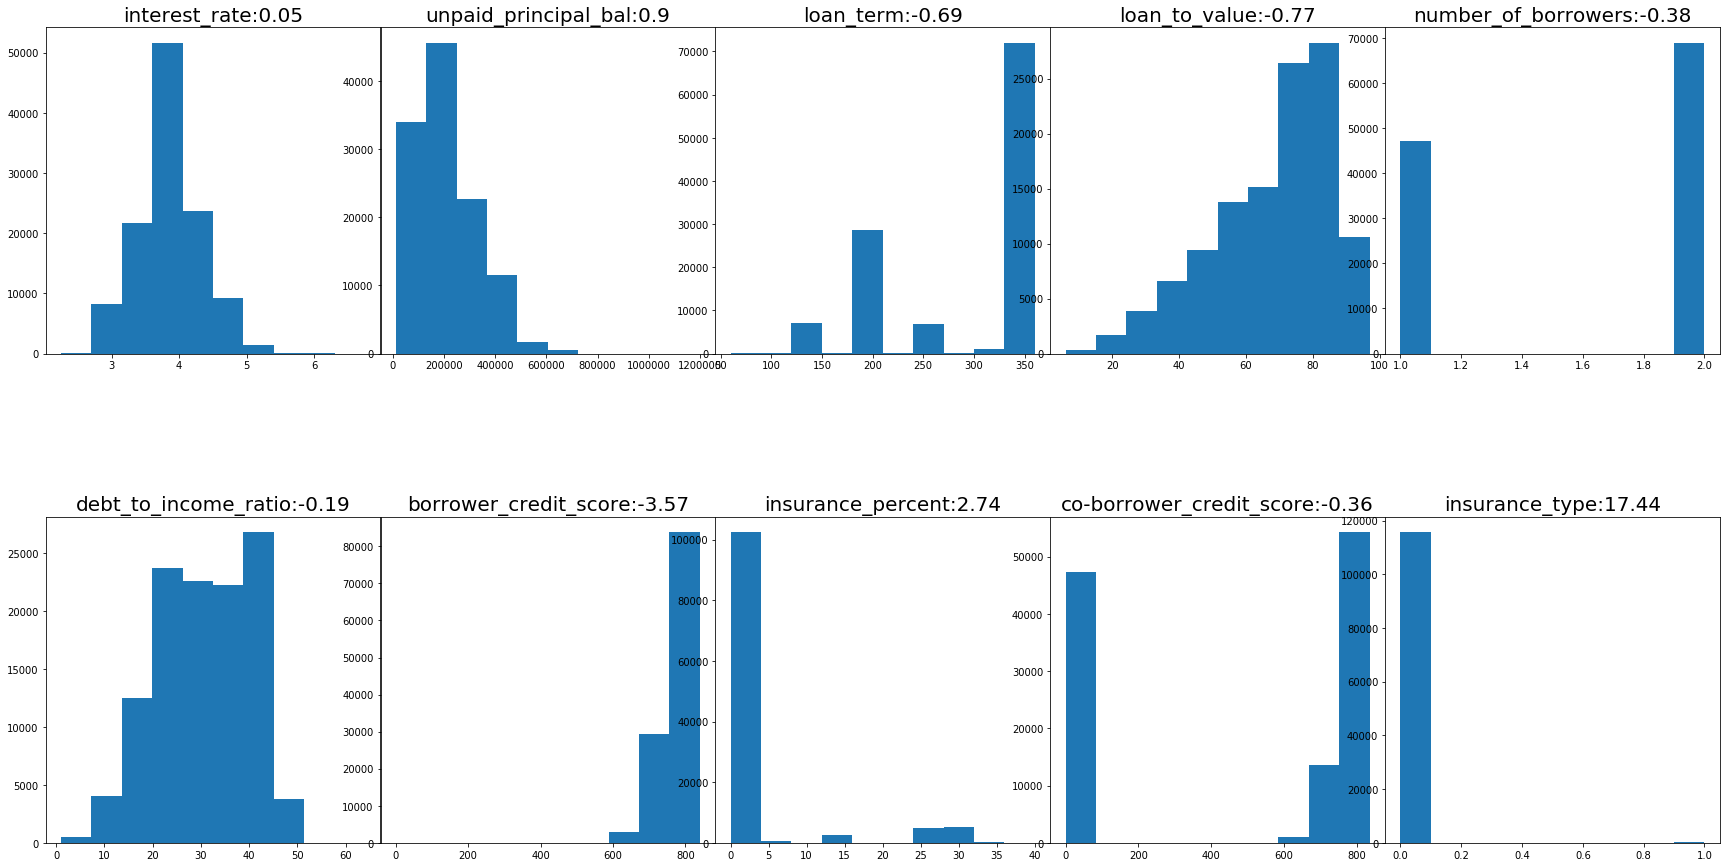

In [14]:
fig, axs = plt.subplots(2,5, figsize=(30, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i,j in zip(num_fea.columns,range(10)):
    axs[j].hist(num_fea[i])
    axs[j].set_title(i+':' + str(round(num_fea[i].skew(),2)),fontsize=20)

#### Insights
    Tried all Distribution Charts,but figured out that m1 to m12 are highly skewed as most of the values are 0
    Interest_rate is alomst normally distributed



In [15]:
num_fea['m13'].value_counts()

0    115422
1       636
Name: m13, dtype: int64

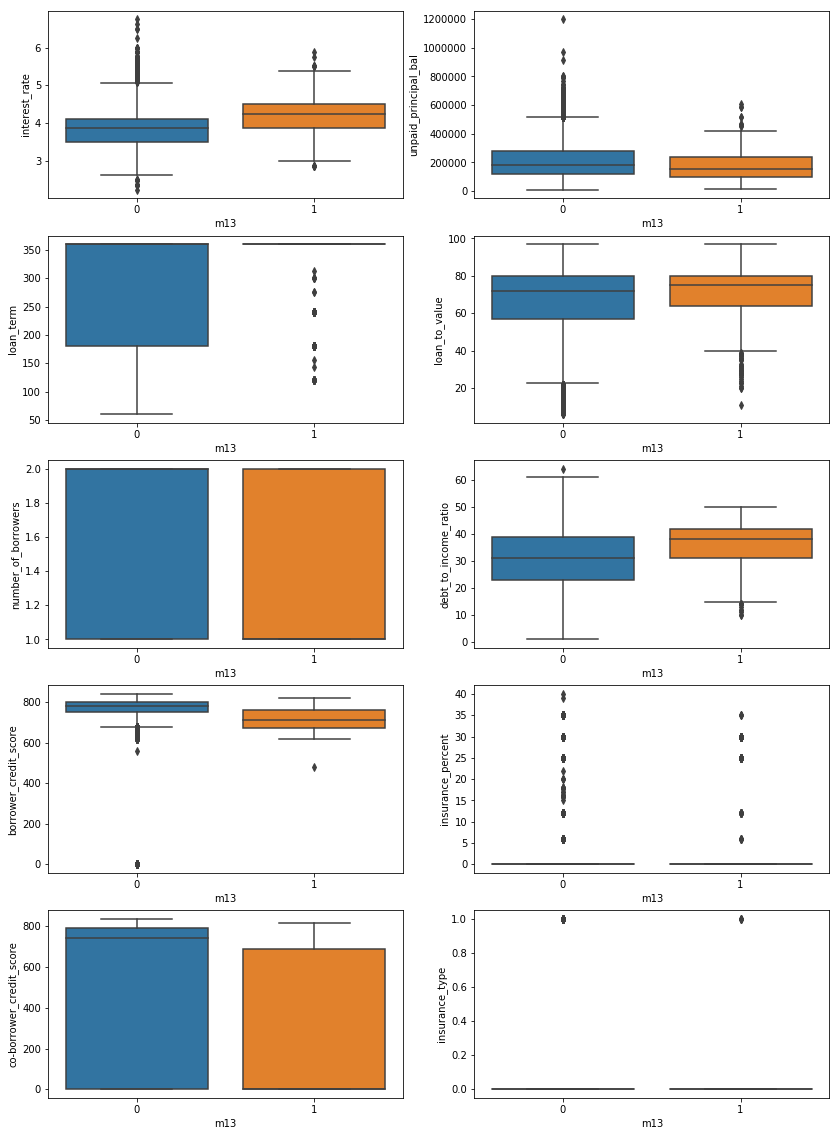

In [16]:
fig , ax = plt.subplots(5,2,figsize=(14,20))
# print(ax)
ax = ax.ravel()
# print(ax)
for i,j in zip(num_fea.columns,ax):
#     plt.boxplot(num_fea[i])
    sns.boxplot(num_fea['m13'],num_fea[i],ax=j)


In [17]:
mnth = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']
for i in mnth:
    print(pd.crosstab(num_fea[i],num_fea['m13']))
    print()

m13       0    1
m1              
0    115140  589
1       250   43
2        27    3
3         5    1

m13       0    1
m2              
0    115261  583
1       153   43
2         5    8
3         2    1
4         1    1

m13       0    1
m3              
0    115287  581
1       125   42
2         6    8
3         1    3
4         2    1
5         1    1

m13       0    1
m4              
0    115307  553
1       104   64
2         6   10
3         3    5
4         1    2
5         0    1
6         1    1

m13       0    1
m5              
0    115234  518
1       169   80
2        10   23
3         5    7
4         2    4
5         1    2
6         0    1
7         1    1

m13       0    1
m6              
0    115265  520
1       145   69
2         5   21
3         4   12
4         3    6
5         0    4
6         0    2
7         0    1
8         0    1

m13       0    1
m7              
0    115236  492
1       170   96
2        11   17
3         1   12
4         2    6
5       

In [18]:
data_raw['deliq_sum'] = data_raw[mnth].sum(1)

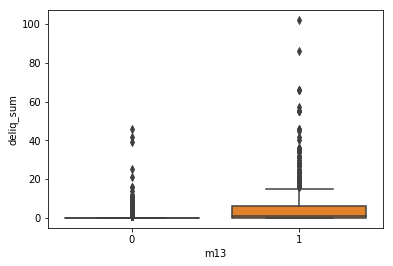

In [19]:
sns.boxplot(data_raw['m13'],data_raw['deliq_sum'])

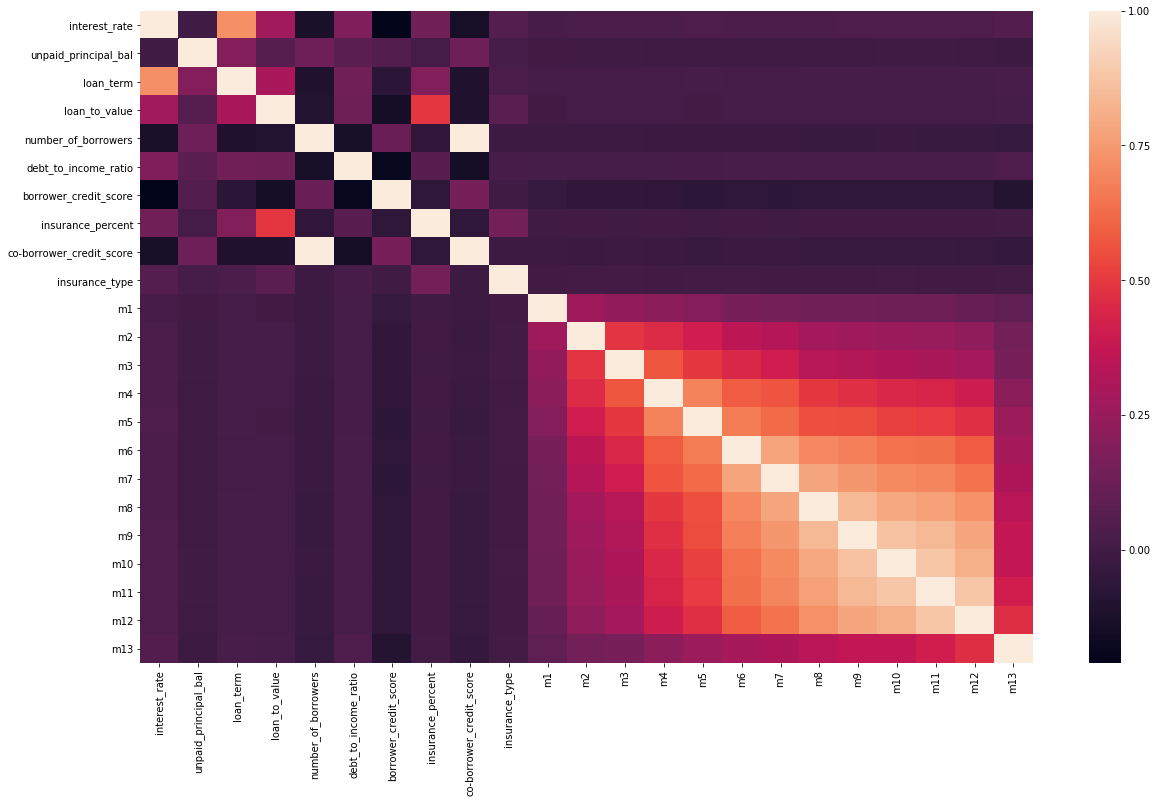

In [20]:
plt.figure(figsize=(20,12))
sns.heatmap(num_fea.corr())

In [21]:
num_fea['loan_id']=num_fea.index
vif = []
for i in range(len(num_fea.columns)):
    vif.append(variance_inflation_factor(num_fea.values,i))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
pd.DataFrame({'Feature':num_fea.columns,'vif':vif})

,Feature,vif
0,interest_rate,2.166196
1,unpaid_principal_bal,1.119231
2,loan_term,2.309670
3,loan_to_value,1.423870
4,number_of_borrowers,58.742619
5,debt_to_income_ratio,1.084515
6,borrower_credit_score,0.493528
7,insurance_percent,1.344911
8,co-borrower_credit_score,60.138336
9,insurance_type,1.025147


#### Relationship with categorical data

In [23]:
cat_fea.shape

(116058, 5)

In [24]:
cat_fea.columns

Index(['source', 'financial_institution', 'origination_date',
       'first_payment_date', 'loan_purpose'],
      dtype='object')

In [25]:
cat_fea.source.value_counts()

X    63858
Y    37554
Z    14646
Name: source, dtype: int64

In [26]:
pd.crosstab(data_raw.source,data_raw['m13'])

m13,0,1
source,,
X,63553,305
Y,37307,247
Z,14562,84


In [27]:
for i in cat_fea.columns:
    print(pd.crosstab(data_raw[i],data_raw['m13']),'\n\n')

m13         0    1
source            
X       63553  305
Y       37307  247
Z       14562   84 


m13                              0    1
financial_institution                  
Anderson-Taylor                480    3
Browning-Hart                31677  175
Chapman-Mcmahon                388    0
Cole, Brooks and Vincent      1630   12
Edwards-Hoffman               4816   41
Martinez, Duffy and Bird      4692   23
Miller, Mcclure and Allen     3139   19
Nicholson Group               2105   11
OTHER                        49430  269
Richards-Walters              1454    5
Richardson Ltd                 472    1
Romero, Woods and Johnson      748    2
Sanchez, Hays and Wilkerson    851    2
Sanchez-Robinson              1192    1
Suarez Inc                    1785    5
Swanson, Newton and Miller    6828   46
Taylor, Hunt and Rodriguez    1255    4
Thornton-Davis                 648    3
Turner, Baldwin and Rhodes    1832   14 


m13                   0    1
origination_date            
2

In [28]:
data_raw.columns

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13', 'deliq_sum'],
      dtype='object')

In [29]:
# loading Test data

test_data = pd.read_csv('test.csv')


In [30]:
data_raw.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m5,m6,m7,m8,m9,m10,m11,m12,m13,deliq_sum
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,1,0,0,0,0,0,1,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,1,0,1,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,1,0
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,1,1,1,1,1,4
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,4,5,6,7,8,9,10,11,1,66


In [31]:
data_raw['origination_date'] = data_raw['origination_date'].map({'2012-01-01':1,'2012-02-01':2,'2012-03-01':3})
data_raw.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m5,m6,m7,m8,m9,m10,m11,m12,m13,deliq_sum
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,3,05/2012,95,1.0,...,0,0,1,0,0,0,0,0,1,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,1,03/2012,72,1.0,...,0,0,0,0,0,0,1,0,1,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,1,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,1,0
3,601385667462,X,OTHER,4.750,135000,360,2,04/2012,46,2.0,...,0,0,0,0,1,1,1,1,1,4
4,273870029961,X,OTHER,4.750,124000,360,2,04/2012,80,1.0,...,4,5,6,7,8,9,10,11,1,66


In [32]:
data_raw['first_payment_date'] = data_raw['first_payment_date'].map({'02/2012':2,'03/2012':3,'04/2012':4,'05/2012':5})
data_raw.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m5,m6,m7,m8,m9,m10,m11,m12,m13,deliq_sum
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,3,5,95,1.0,...,0,0,1,0,0,0,0,0,1,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,1,3,72,1.0,...,0,0,0,0,0,0,1,0,1,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,1,3,49,1.0,...,0,0,0,0,0,0,0,0,1,0
3,601385667462,X,OTHER,4.750,135000,360,2,4,46,2.0,...,0,0,0,0,1,1,1,1,1,4
4,273870029961,X,OTHER,4.750,124000,360,2,4,80,1.0,...,4,5,6,7,8,9,10,11,1,66


In [33]:
test_data.origination_date.value_counts()

# data_raw['origination_date'] = data_raw['origination_date'].map({'2012-01-01':1,'2012-02-01':2,'2012-03-01':3})
# data_raw['first_payment_date'] = data_raw['first_payment_date'].map({'02/2012':2,'03/2012':3,'04/2012':4,'05/2012':5})

01/02/12    16423
01/01/12    15051
01/03/12     4392
Name: origination_date, dtype: int64

In [34]:
test_data.first_payment_date.value_counts()

Apr-12    16551
Mar-12    14661
May-12     4510
Feb-12      144
Name: first_payment_date, dtype: int64

In [35]:
test_data['origination_date'] = test_data['origination_date'].map({'01/01/12':1,'01/02/12':2,'01/03/12':3})
test_data['first_payment_date'] = test_data['first_payment_date'].map({'Apr-12':4,'Mar-12':3,'May-12':5,'Feb-12':2})
test_data.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,2,4,75,1,...,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,2,4,80,2,...,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,1,3,75,1,...,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,2,4,41,2,...,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,2,4,53,2,...,0,0,0,0,0,0,0,0,0,0


In [36]:
pd.crosstab(data_raw.financial_institution,data_raw.m13)

m13,0,1
financial_institution,,
Anderson-Taylor,480,3
Browning-Hart,31677,175
Chapman-Mcmahon,388,0
"Cole, Brooks and Vincent",1630,12
Edwards-Hoffman,4816,41
"Martinez, Duffy and Bird",4692,23
"Miller, Mcclure and Allen",3139,19
Nicholson Group,2105,11
OTHER,49430,269


In [37]:
data_raw['financial_ins_new'] = data_raw['financial_institution'].apply(lambda x: 1 if(x=='Browning-Hart') or 
                                                                       (x=='OTHER') else 0)
data_raw['source_new'] = data_raw['source'].apply(lambda x: 1 if(x=='X') or(x=='Y') else 0)
data_raw.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m7,m8,m9,m10,m11,m12,m13,deliq_sum,financial_ins_new,source_new
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,3,5,95,1.0,...,1,0,0,0,0,0,1,1,0,0
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,1,3,72,1.0,...,0,0,0,0,1,0,1,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,1,3,49,1.0,...,0,0,0,0,0,0,1,0,0,0
3,601385667462,X,OTHER,4.750,135000,360,2,4,46,2.0,...,0,0,1,1,1,1,1,4,1,1
4,273870029961,X,OTHER,4.750,124000,360,2,4,80,1.0,...,6,7,8,9,10,11,1,66,1,1


In [38]:
data_raw.shape


(116058, 32)

In [39]:
data_raw = pd.concat([data_raw,pd.get_dummies(data_raw['source']),pd.get_dummies(data_raw['financial_institution']),
                          pd.get_dummies(data_raw['loan_purpose'])],axis=1)
data_raw.shape

(116058, 57)

In [40]:
data_for = data_raw.drop(['source','loan_purpose','financial_institution','loan_id'],axis =1)
data_for.head()

,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,...,"Sanchez, Hays and Wilkerson",Sanchez-Robinson,Suarez Inc,"Swanson, Newton and Miller","Taylor, Hunt and Rodriguez",Thornton-Davis,"Turner, Baldwin and Rhodes",A23,B12,C86
0,4.250,214000,360,3,5,95,1.0,22.0,694.0,30.0,...,0,0,0,0,0,0,1,0,0,1
1,4.875,144000,360,1,3,72,1.0,44.0,697.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,3.250,366000,180,1,3,49,1.0,33.0,780.0,0.0,...,0,0,0,0,0,1,0,0,1,0
3,4.750,135000,360,2,4,46,2.0,44.0,633.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,4.750,124000,360,2,4,80,1.0,43.0,681.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [41]:
data_for.columns

Index(['interest_rate', 'unpaid_principal_bal', 'loan_term',
       'origination_date', 'first_payment_date', 'loan_to_value',
       'number_of_borrowers', 'debt_to_income_ratio', 'borrower_credit_score',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'm13', 'deliq_sum', 'financial_ins_new', 'source_new', 'X', 'Y', 'Z',
       'Anderson-Taylor', 'Browning-Hart', 'Chapman-Mcmahon',
       'Cole, Brooks and Vincent', 'Edwards-Hoffman',
       'Martinez, Duffy and Bird', 'Miller, Mcclure and Allen',
       'Nicholson Group', 'OTHER', 'Richards-Walters', 'Richardson Ltd',
       'Romero, Woods and Johnson', 'Sanchez, Hays and Wilkerson',
       'Sanchez-Robinson', 'Suarez Inc', 'Swanson, Newton and Miller',
       'Taylor, Hunt and Rodriguez', 'Thornton-Davis',
       'Turner, Baldwin and Rhodes', 'A23', 'B12', 'C86'],
      dtype='object')

### Dimensionality Reduction

In [42]:
X_train,X_test,y_train,y_test = train_test_split(data_for.drop(['m13'],axis=1),data_for['m13'],test_size=0.2,random_state=15)


In [43]:
X_train.shape

(92846, 52)

#### RFE(Logistic Regression)

In [44]:
for n in range(8,30,2):
    log_reg = LogisticRegression()
    rfe = RFE(estimator=log_reg,n_features_to_select=n)
    rfe.fit(X_train,y_train)
    print(f"Top {n} features")
    print(rfe.score(X_train,y_train))
    print("F1-score:",f1_score(y_test,rfe.predict(X_test)))
    selec_fea = pd.DataFrame({'cols':X_train.columns,'rank':rfe.ranking_})
    print(selec_fea[selec_fea['rank']==1]['cols'].unique(),'\n\n')

Top 8 features
0.9957133317536566
F1-score: 0.37333333333333335
['number_of_borrowers' 'insurance_type' 'm6' 'm12' 'source_new' 'Z'
 'Taylor, Hunt and Rodriguez' 'A23'] 


Top 10 features
0.9957133317536566
F1-score: 0.37333333333333335
['number_of_borrowers' 'insurance_type' 'm6' 'm12' 'source_new' 'Z'
 'Taylor, Hunt and Rodriguez' 'A23' 'B12' 'C86'] 


Top 12 features
0.9956487086142645
F1-score: 0.4203821656050955
['interest_rate' 'number_of_borrowers' 'insurance_type' 'm6' 'm12'
 'source_new' 'X' 'Z' 'Taylor, Hunt and Rodriguez' 'A23' 'B12' 'C86'] 


Top 14 features
0.9956379380910325
F1-score: 0.4203821656050955
['interest_rate' 'number_of_borrowers' 'insurance_type' 'm3' 'm6' 'm12'
 'source_new' 'X' 'Y' 'Z' 'Taylor, Hunt and Rodriguez' 'A23' 'B12' 'C86'] 


Top 16 features
0.9960687590203132
F1-score: 0.45283018867924535
['interest_rate' 'number_of_borrowers' 'insurance_type' 'm3' 'm5' 'm6'
 'm12' 'deliq_sum' 'source_new' 'X' 'Y' 'Z' 'Taylor, Hunt and Rodriguez'
 'A23' 'B12' 'C86

In [49]:
rfc = RandomForestClassifier()
for n in range(8,30,2):
    rfe_rfc = RFE(estimator=rfc,n_features_to_select=n)
    rfe_rfc.fit(X_train,y_train)
    print(f"Top {n} features")
    print(rfe_rfc.score(X_train,y_train))
    print("F1-score:",f1_score(y_test,rfe_rfc.predict(X_test)))
    selec_fea = pd.DataFrame({'cols':X_train.columns,'rank':rfe_rfc.ranking_})
    print(selec_fea[selec_fea['rank']==1]['cols'].unique(),'\n\n')

Top 8 features
0.9991060465717424
F1-score: 0.4539877300613496
['interest_rate' 'unpaid_principal_bal' 'loan_to_value'
 'debt_to_income_ratio' 'borrower_credit_score' 'co-borrower_credit_score'
 'm12' 'deliq_sum'] 


Top 10 features
0.9992029812808306
F1-score: 0.45783132530120485
['interest_rate' 'unpaid_principal_bal' 'loan_to_value'
 'debt_to_income_ratio' 'borrower_credit_score' 'co-borrower_credit_score'
 'm9' 'm11' 'm12' 'deliq_sum'] 


Top 12 features
0.9992568338969907
F1-score: 0.44171779141104295
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'first_payment_date'
 'loan_to_value' 'debt_to_income_ratio' 'borrower_credit_score'
 'co-borrower_credit_score' 'm9' 'm11' 'm12' 'deliq_sum'] 


Top 14 features
0.9991814402343666
F1-score: 0.4177215189873417
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'origination_date'
 'first_payment_date' 'loan_to_value' 'debt_to_income_ratio'
 'borrower_credit_score' 'co-borrower_credit_score' 'm9' 'm10' 'm11' 'm12'
 'deliq_sum'] 


To

In [50]:
ada = AdaBoostClassifier()
for n in range(8,30,2):
    rfe_ada = RFE(estimator=ada,n_features_to_select=n)
    rfe_ada.fit(X_train,y_train)
    print(f"Top {n} features")
    print(rfe_ada.score(X_train,y_train))
    print("F1-score:",f1_score(y_test,rfe_ada.predict(X_test)))
    selec_fea = pd.DataFrame({'cols':X_train.columns,'rank':rfe_ada.ranking_})
    print(selec_fea[selec_fea['rank']==1]['cols'].unique(),'\n\n')

Top 8 features
0.995961053787993
F1-score: 0.4852071005917159
['interest_rate' 'unpaid_principal_bal' 'loan_to_value'
 'debt_to_income_ratio' 'borrower_credit_score' 'co-borrower_credit_score'
 'm12' 'deliq_sum'] 


Top 10 features
0.995971824311225
F1-score: 0.48235294117647054
['interest_rate' 'unpaid_principal_bal' 'loan_to_value'
 'debt_to_income_ratio' 'borrower_credit_score' 'co-borrower_credit_score'
 'm12' 'deliq_sum' 'Taylor, Hunt and Rodriguez'
 'Turner, Baldwin and Rhodes'] 


Top 12 features
0.995928742218297
F1-score: 0.47674418604651164
['interest_rate' 'unpaid_principal_bal' 'loan_to_value'
 'debt_to_income_ratio' 'borrower_credit_score' 'co-borrower_credit_score'
 'm12' 'deliq_sum' 'Edwards-Hoffman' 'Sanchez-Robinson'
 'Taylor, Hunt and Rodriguez' 'Turner, Baldwin and Rhodes'] 


Top 14 features
0.9958856601253689
F1-score: 0.4942528735632184
['interest_rate' 'unpaid_principal_bal' 'loan_to_value'
 'debt_to_income_ratio' 'borrower_credit_score' 'co-borrower_credit_score

In [51]:
dt = DecisionTreeClassifier()
for n in range(8,30,2):
    rfe_dt = RFE(estimator=dt,n_features_to_select=n)
    rfe_dt.fit(X_train,y_train)
    print(f"Top {n} features")
    print(rfe_dt.score(X_train,y_train))
    print("F1-score:",f1_score(y_test,rfe_dt.predict(X_test)))
    selec_fea = pd.DataFrame({'cols':X_train.columns,'rank':rfe_dt.ranking_})
    print(selec_fea[selec_fea['rank']==1]['cols'].unique(),'\n\n')

Top 8 features
1.0
F1-score: 0.3169811320754716
['interest_rate' 'unpaid_principal_bal' 'loan_to_value'
 'debt_to_income_ratio' 'borrower_credit_score' 'co-borrower_credit_score'
 'm12' 'deliq_sum'] 


Top 10 features
1.0
F1-score: 0.2803030303030303
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'origination_date'
 'loan_to_value' 'debt_to_income_ratio' 'borrower_credit_score'
 'co-borrower_credit_score' 'm12' 'deliq_sum'] 


Top 12 features
1.0
F1-score: 0.29133858267716534
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'origination_date'
 'first_payment_date' 'loan_to_value' 'debt_to_income_ratio'
 'borrower_credit_score' 'co-borrower_credit_score' 'm12' 'deliq_sum'
 'B12'] 


Top 14 features
1.0
F1-score: 0.2835249042145594
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'origination_date'
 'first_payment_date' 'loan_to_value' 'debt_to_income_ratio'
 'borrower_credit_score' 'co-borrower_credit_score' 'm12' 'deliq_sum'
 'source_new' 'B12' 'C86'] 


Top 16 features
1.0


In [52]:
from xgboost import XGBClassifier

In [53]:
xg = XGBClassifier()
for n in range(8,30,2):
    rfe_xg = RFE(estimator=xg,n_features_to_select=n)
    rfe_xg.fit(X_train,y_train)
    print(f"Top {n} features")
    print(rfe_xg.score(X_train,y_train))
    print("F1-score:",f1_score(y_test,rfe_xg.predict(X_test)))
    selec_fea = pd.DataFrame({'cols':X_train.columns,'rank':rfe_xg.ranking_})
    print(selec_fea[selec_fea['rank']==1]['cols'].unique(),'\n\n')

Top 8 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9962949400081856
F1-score: 0.48192771084337344
['debt_to_income_ratio' 'borrower_credit_score' 'co-borrower_credit_score'
 'm9' 'm11' 'm12' 'deliq_sum' 'Edwards-Hoffman'] 


Top 10 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9962518579152575
F1-score: 0.4939759036144579
['loan_term' 'debt_to_income_ratio' 'borrower_credit_score'
 'co-borrower_credit_score' 'm7' 'm9' 'm11' 'm12' 'deliq_sum'
 'Edwards-Hoffman'] 


Top 12 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9962949400081856


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


F1-score: 0.48192771084337344
['interest_rate' 'loan_term' 'debt_to_income_ratio'
 'borrower_credit_score' 'co-borrower_credit_score' 'insurance_type' 'm7'
 'm9' 'm11' 'm12' 'deliq_sum' 'Edwards-Hoffman'] 


Top 14 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9964026452405058
F1-score: 0.48192771084337344
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'debt_to_income_ratio'
 'borrower_credit_score' 'co-borrower_credit_score' 'insurance_type' 'm7'
 'm9' 'm11' 'm12' 'deliq_sum' 'source_new' 'Edwards-Hoffman'] 


Top 16 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9963703336708097
F1-score: 0.4596273291925465
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'loan_to_value'
 'debt_to_income_ratio' 'borrower_credit_score' 'co-borrower_credit_score'
 'insurance_type' 'm7' 'm9' 'm11' 'm12' 'deliq_sum' 'source_new'
 'Edwards-Hoffman' 'A23'] 


Top 18 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9963595631475777
F1-score: 0.45000000000000007
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'loan_to_value'
 'debt_to_income_ratio' 'borrower_credit_score' 'co-borrower_credit_score'
 'insurance_type' 'm5' 'm7' 'm9' 'm11' 'm12' 'deliq_sum' 'source_new'
 'Edwards-Hoffman' 'A23' 'B12'] 


Top 20 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9963918747172738
F1-score: 0.4691358024691358
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'first_payment_date'
 'loan_to_value' 'debt_to_income_ratio' 'borrower_credit_score'
 'co-borrower_credit_score' 'insurance_type' 'm4' 'm5' 'm7' 'm9' 'm11'
 'm12' 'deliq_sum' 'source_new' 'Edwards-Hoffman' 'A23' 'B12'] 


Top 22 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9963703336708097
F1-score: 0.4691358024691358
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'first_payment_date'
 'loan_to_value' 'debt_to_income_ratio' 'borrower_credit_score'
 'co-borrower_credit_score' 'insurance_type' 'm4' 'm5' 'm7' 'm9' 'm11'
 'm12' 'deliq_sum' 'source_new' 'Edwards-Hoffman' 'Nicholson Group'
 'Richards-Walters' 'A23' 'B12'] 


Top 24 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9963811041940418
F1-score: 0.4785276073619632
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'first_payment_date'
 'loan_to_value' 'debt_to_income_ratio' 'borrower_credit_score'
 'co-borrower_credit_score' 'insurance_type' 'm4' 'm5' 'm7' 'm9' 'm10'
 'm11' 'm12' 'deliq_sum' 'source_new' 'Edwards-Hoffman' 'Nicholson Group'
 'Richards-Walters' 'Sanchez, Hays and Wilkerson' 'A23' 'B12'] 


Top 26 features


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9963811041940418
F1-score: 0.4785276073619632
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'first_payment_date'
 'loan_to_value' 'debt_to_income_ratio' 'borrower_credit_score'
 'co-borrower_credit_score' 'insurance_type' 'm4' 'm5' 'm7' 'm9' 'm10'
 'm11' 'm12' 'deliq_sum' 'source_new' 'Edwards-Hoffman'
 'Martinez, Duffy and Bird' 'Nicholson Group' 'OTHER' 'Richards-Walters'
 'Sanchez, Hays and Wilkerson' 'A23' 'B12'] 


Top 28 features
0.9963811041940418
F1-score: 0.4785276073619632
['interest_rate' 'unpaid_principal_bal' 'loan_term' 'first_payment_date'
 'loan_to_value' 'debt_to_income_ratio' 'borrower_credit_score'
 'co-borrower_credit_score' 'insurance_type' 'm4' 'm5' 'm7' 'm9' 'm10'
 'm11' 'm12' 'deliq_sum' 'financial_ins_new' 'source_new' 'Browning-Hart'
 'Edwards-Hoffman' 'Martinez, Duffy and Bird' 'Nicholson Group' 'OTHER'
 'Richards-Walters' 'Sanchez, Hays and Wilkerson' 'A23' 'B12'] 




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [80]:
# Selecting Top 18 feature from AdaBoostClassifier

cols = ['interest_rate','unpaid_principal_bal','loan_term','first_payment_date',
 'loan_to_value','debt_to_income_ratio','borrower_credit_score','m9','m11','m12','deliq_sum','Z',
 'Edwards-Hoffman','Sanchez-Robinson','Taylor, Hunt and Rodriguez',
 'Thornton-Davis','Turner, Baldwin and Rhodes']

In [81]:
X_train,X_test,y_train,y_test = train_test_split(data_for[cols],data_for['m13'],test_size=0.2,random_state=15)

In [82]:
algos = [LogisticRegression(),RandomForestClassifier(),AdaBoostClassifier(),
         DecisionTreeClassifier(),XGBClassifier(),GradientBoostingClassifier()]
alg = ['LR','RFC','ADB','DTC','XGB','GBC']

In [83]:
for algo,l in zip(algos,alg):
    model = algo
    model.fit(X_train,y_train)
    print(f"\n\nModel:{l} \n f1-score:",f1_score(y_test,model.predict(X_test)))
    print("Performance on train data:",model.score(X_train,y_train))
    print("Performance on test data:",model.score(X_test,y_test))



Model:LR 
 f1-score: 0.15827338129496402
Performance on train data: 0.9944424100122784
Performance on test data: 0.9949595037049802


Model:RFC 
 f1-score: 0.42168674698795183
Performance on train data: 0.9991922107575986
Performance on test data: 0.9958642081681889


Model:ADB 
 f1-score: 0.5088757396449703
Performance on train data: 0.9958964306486009
Performance on test data: 0.99642426331208


Model:DTC 
 f1-score: 0.27586206896551724
Performance on train data: 1.0
Performance on test data: 0.9918576598311218


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:




Model:XGB 
 f1-score: 0.4720496894409938


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Performance on train data: 0.9963703336708097
Performance on test data: 0.9963381009822505


Model:GBC 
 f1-score: 0.40236686390532544
Performance on train data: 0.9967580725071624
Performance on test data: 0.9956488023436154


In [84]:
test_data.columns

Index(['loan_id', 'source', 'financial_institution', 'interest_rate',
       'unpaid_principal_bal', 'loan_term', 'origination_date',
       'first_payment_date', 'loan_to_value', 'number_of_borrowers',
       'debt_to_income_ratio', 'borrower_credit_score', 'loan_purpose',
       'insurance_percent', 'co-borrower_credit_score', 'insurance_type', 'm1',
       'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
       'deliq_sum', 'financial_ins_new', 'source_new', 'X', 'Y', 'Z',
       'Anderson-Taylor', 'Browning-Hart', 'Chapman-Mcmahon',
       'Cole, Brooks and Vincent', 'Edwards-Hoffman',
       'Martinez, Duffy and Bird', 'Miller, Mcclure and Allen',
       'Nicholson Group', 'OTHER', 'Richards-Walters', 'Richardson Ltd',
       'Romero, Woods and Johnson', 'Sanchez, Hays and Wilkerson',
       'Sanchez-Robinson', 'Suarez Inc', 'Swanson, Newton and Miller',
       'Taylor, Hunt and Rodriguez', 'Thornton-Davis',
       'Turner, Baldwin and Rhodes', 'A23', 'B12', 'C

In [70]:
test_data.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,2,4,75,1,...,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,2,4,80,2,...,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,1,3,75,1,...,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,2,4,41,2,...,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,2,4,53,2,...,0,0,0,0,0,0,0,0,0,0


In [71]:
cols

['interest_rate',
 'unpaid_principal_bal',
 'loan_term',
 'first_payment_date',
 'loan_to_value',
 'debt_to_income_ratio',
 'borrower_credit_score',
 'co-borrower_credit_score',
 'm9',
 'm11',
 'm12',
 'deliq_sum',
 'Z',
 'Edwards-Hoffman',
 'Sanchez-Robinson',
 'Taylor, Hunt and Rodriguez',
 'Thornton-Davis',
 'Turner, Baldwin and Rhodes']

## Preparing Test Data for final Testing

In [72]:
test_data['deliq_sum'] = test_data[mnth].sum(1)

In [73]:
test_data['financial_ins_new'] = test_data['financial_institution'].apply(lambda x: 1 if(x=='Browning-Hart') or 
                                                                       (x=='OTHER') else 0)
test_data['source_new'] = test_data['source'].apply(lambda x: 1 if(x=='X') or(x=='Y') else 0)
test_data.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m6,m7,m8,m9,m10,m11,m12,deliq_sum,financial_ins_new,source_new
0,1,Y,Browning-Hart,3.875,417000,360,2,4,75,1,...,0,0,0,0,0,0,0,0,1,1
1,2,X,OTHER,4.500,113000,360,2,4,80,2,...,0,0,0,0,0,0,0,0,1,1
2,3,Y,OTHER,4.500,72000,360,1,3,75,1,...,0,0,0,0,0,0,0,0,1,1
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,2,4,41,2,...,0,0,0,0,0,0,0,0,0,1
4,5,X,Browning-Hart,3.250,166000,180,2,4,53,2,...,0,0,0,0,0,0,0,0,1,1


In [75]:
test_data = pd.concat([test_data,pd.get_dummies(test_data['source']),pd.get_dummies(test_data['financial_institution']),
                          pd.get_dummies(test_data['loan_purpose'])],axis=1)
test_data.shape

(35866, 56)

In [76]:
data_raw.shape

(116058, 57)

In [87]:
test_fea = test_data[cols]

In [88]:
X_train,X_test,y_train,y_test = train_test_split(data_for[cols],data_for['m13'],test_size=0.0,random_state=15)

In [89]:
model = AdaBoostClassifier()
model.fit(X_train,y_train)
model.predict(test_fea).sum()

94

In [91]:
prob = model.predict_proba(test_fea)

In [94]:
prob.shape

(35866, 2)

In [116]:
test_pred = []
for i in prob[:,1:2]:
    if i > 0.495:
        test_pred.append(1)
    else:
        test_pred.append(0)
        
        

In [102]:
prob[0:5,1:2]

array([[0.46541349],
       [0.4678354 ],
       [0.47665233],
       [0.46585623],
       [0.45890492]])

In [117]:
sum(test_pred)

139

In [131]:
file = pd.DataFrame({'loan_id':test_data.loan_id,'m13':test_pred})

In [129]:
file.drop(file.index,inplace=True)

In [133]:
file.to_csv('Final_sub.csv',index=False)